In [1]:
# Load libraries and functions
%load_ext autoreload
%autoreload 2
%matplotlib inline
RANDOM_STATE = 42  # Pseudo-random state

from utils import *
sns.set_palette("tab10") # Default seaborn theme

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Upload dataset
fn_vae_data = glob.glob('./data/Updated*.pkl')
latest_fn_vae_data = max(fn_vae_data, key=os.path.getctime)

print("Loading... ",latest_fn_vae_data)
with open(latest_fn_vae_data, "rb") as f:
    vae_data_main = pickle.load(f)
print("Done")


Loading...  ./data/Updated_VAE_Data_Main_0821_0932.pkl
Done


## Calculate how many patients had how many cases

In [3]:
# Print number of patients and number of cases 
print('Total patients: ', vae_data_main[['ID']].groupby('ID').max().shape[0])
print('Total ICU admissions: ', vae_data_main[['ID_subid']].groupby('ID_subid').max().shape[0])
vae_data_main[['ID_subid', 'group']].groupby('ID_subid').max().group.value_counts()

Total patients:  2708
Total ICU admissions:  2957


No HAI          1594
Other HAI        690
VA-HARTI         457
NVA-HARTI        197
VA+NVA HARTI      19
Name: group, dtype: int64

### Number of cases per one ICU admission

In [4]:
# Define function

class AggFuncWFlag():
    def __init__(self):
        self.flag = False
        
    def __call__(self, x):
        if not self.flag:
            self.flag = True
            
            if x.iloc[0] == 0. and x.iloc[1] == 1:
                return 1
            
            elif x.iloc[0] == 0:
                return 0
            elif x.iloc[0] == 1.:
                return 1
            else:
                raise ValueError()
         
        return x.iloc[0] == 0. and x.iloc[1] == 1

In [5]:
# Calculation

agg_func = lambda x: x.iloc[0] == 0. and x.iloc[1] == 1
agg_func = AggFuncWFlag()

result = []
for COL in ['non_vap_resp_hai', 'vap', 'infection_respiratory']:

    res = []
    for uid in vae_data_main.loc[vae_data_main[COL] > 0, 'ID_subid'].unique():
        agg_func = AggFuncWFlag()
        res.append(
            vae_data_main.loc[vae_data_main.ID_subid == uid, COL].rolling(2).agg(agg_func).sum())

    # Check guys w/ one line only
    one_liners = vae_data_main.loc[vae_data_main[COL] > 0, 'ID_subid'].unique()
    one_liners_ids = one_liners[[i for (i,j) in enumerate(res) if j == 0]]

    assert vae_data_main.loc[(vae_data_main.ID_subid.isin(one_liners_ids) & 
                              vae_data_main[COL] > 0)].shape[0] == len(one_liners_ids)

    # OK
    result += [pd.Series(res).replace(0, 1).value_counts()]
    
pd.concat(result, axis=1)

,0,1,2
1.0,212.0,433.0,612
2.0,4.0,37.0,51
3.0,NaN,5.0,8
4.0,NaN,NaN,1
6.0,NaN,1.0,1


In [6]:
total = pd.Series(res).replace(0, 1).value_counts()
print('Total HARTI cases: ', sum(total.index * total.values))

Total HARTI cases:  748.0


## The onset of HARTI

Median day in ICU when NVA-HARTI begins:  4.0
Median day in ICU when VA-HARTI begins:  8.0


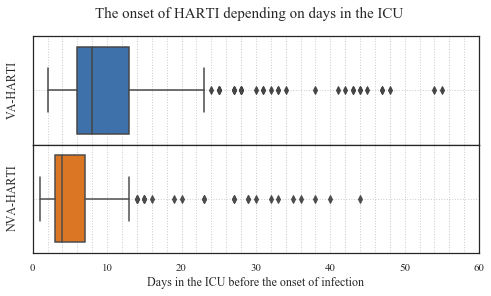

In [8]:
# The onset of HARTI depending on days in the ICU
nva = vae_data_main.loc[vae_data_main['group'] == 'NVA-HARTI']
nva = nva.loc[:, ['day_in_icu_bid', 'ID_subid']].groupby('ID_subid').max()
print('Median day in ICU when NVA-HARTI begins: ', nva.median()[0])

vap = vae_data_main.loc[vae_data_main['group'] == 'VA-HARTI']
vap = vap.loc[:, ['day_in_icu_bid', 'ID_subid']].groupby('ID_subid').max()
print('Median day in ICU when VA-HARTI begins: ', vap.median()[0])

fig, (ax, ax1) = plt.subplots(2, figsize=(8,4))
fig.suptitle('The onset of HARTI depending on days in the ICU', fontsize=15)
colors_sns = ['medium blue']
sns.set_palette(sns.xkcd_palette(colors_sns))
sns.boxplot(x=vap, orient='h', ax=ax)
ax.grid(linestyle='dotted')
ax.set_xlabel('')
ax.set_xticklabels([''])
ax.set_xlim(0,60)
ax.set_ylabel('VA-HARTI')
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both')

colors_sns = ['orange']
sns.set_palette(sns.xkcd_palette(colors_sns))
sns.boxplot(x=nva, orient='h', ax=ax1)
ax1.minorticks_on()
ax1.grid(linestyle='dotted', which='both')
ax1.set_xlabel('Days in the ICU before the onset of infection')
ax1.set_xlim(0,60)
ax1.set_ylabel('NVA-HARTI')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./pictures/onset_all.pdf', dpi=600)

# Restore default colors
sns.set_palette("tab10")

Median days on ventilation when VA-HARTI begins:  6.0


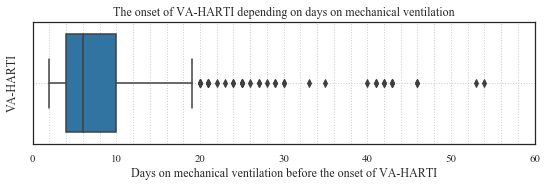

In [9]:
# The onset of VA-HARTI depending on days on mechanical ventilation
vap = vae_data_main.loc[vae_data_main['group'] == 'VA-HARTI']
vap = vap.loc[:, ['mech_vent_bid', 'ID_subid']].groupby('ID_subid').max()
# Print median days on ventilation before infection
print('Median days on ventilation when VA-HARTI begins: ', vap.median()[0])

fig, ax = plt.subplots(1, figsize=(8, 3))
sns.boxplot(x=vap, orient='h', ax=ax)
ax.set_xlabel('Days on mechanical ventilation before the onset of VA-HARTI')
ax.grid(linestyle='dotted')
ax.set_xlim(0,60)
ax.set_ylabel('VA-HARTI')
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both')
ax.set_title('The onset of VA-HARTI depending on days on mechanical ventilation')
plt.tight_layout()
plt.savefig('./pictures/onset_va.pdf', dpi=600)

## The duration of HARTI

Median duration of VA-HARTI:  9.0
Median duration of NVA-HARTI:  7.0


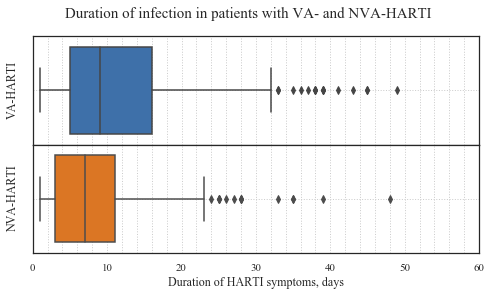

In [10]:
# Define data
nva = vae_data_main.loc[vae_data_main['group'] == 'NVA-HARTI']
nva = nva.loc[:, ['non_vap_resp_hai', 'ID_subid']].groupby('ID_subid').sum()
vap = vae_data_main.loc[vae_data_main['group'] == 'VA-HARTI']
vap = vap.loc[:, ['vap', 'ID_subid']].groupby('ID_subid').sum()

# Print median duration of infections
print('Median duration of VA-HARTI: ', vap.median()[0])
print('Median duration of NVA-HARTI: ', nva.median()[0])

# Plot in boxplot format
fig, (ax, ax1) = plt.subplots(2, figsize=(8,4))
fig.suptitle('Duration of infection in patients with VA- and NVA-HARTI', fontsize=15)
colors_sns = ['medium blue']
sns.set_palette(sns.xkcd_palette(colors_sns))
sns.boxplot(x=vap, orient='h', ax=ax)
ax.set_xlabel('')
ax.set_xticklabels([''])
ax.grid(linestyle='dotted')
ax.set_xlim(0,60)
ax.set_ylabel('VA-HARTI')
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both')

colors_sns = ['orange']
sns.set_palette(sns.xkcd_palette(colors_sns))
sns.boxplot(x=nva, orient='h', ax=ax1)
ax1.minorticks_on()
ax1.grid(linestyle='dotted', which='both')
ax1.set_xlabel('Duration of HARTI symptoms, days')
ax1.set_xlim(0,60)
ax1.set_ylabel('NVA-HARTI')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./pictures/duration_boxplot.pdf', dpi=600)

sns.set_palette("tab10")

________